<a href="https://colab.research.google.com/github/anuj3509/practice-dl/blob/main/dl_hw1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Improving the FashionMNIST Classifier

We will train a logistic classifier (equivalent to using a 3-layer dense neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [21]:
import numpy as np
import torch
import torchvision

In [22]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Let's check that everything has been downloaded.

In [23]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [24]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object given that its first dimension has a size of 1. So we will use the `squeeze` function to get rid of the first dimension.

In [25]:
print(image.squeeze().shape)

torch.Size([28, 28])


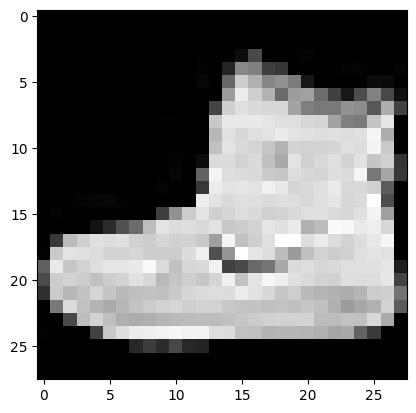

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [27]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's also check the length of the train and test dataloader

In [28]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


The length here depends upon the batch size defined above. Multiplying the length of our dataloader by the batch size should give us back the number of samples in each set.

In [29]:
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


Now let's use it to look at a few images.

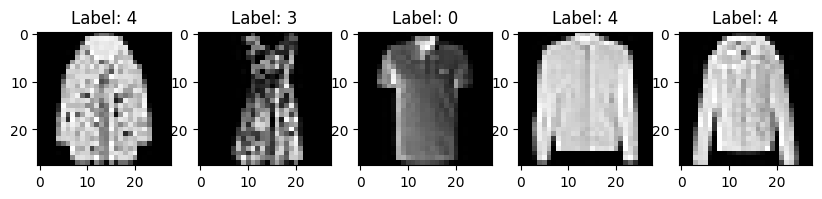

In [30]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Now let's set up our model.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [37]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.fc1 = torch.nn.Linear(28*28, 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 64)
    self.fc4 = torch.nn.Linear(64,10)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)


    # x = x.view(-1, 28*28) # change so 784 vector instead of 28x28 matrix
    # return self.linear(x)
    return x


model = LinearReg().cuda() # Step 1: architecture
print(model)
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method
optimizer = torch.optim.SGD(model.parameters(), lr=0.005) # Step 3: training method


LinearReg(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


Now let's train our model!

In [38]:
train_loss_history = []
test_loss_history = []

for epoch in range(50):
  train_loss = 0.0
  test_loss = 0.0
  correct = 0
  total = 0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images.view(-1, 28*28)) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model(images.view(-1, 28*28))
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
      for idx, i in enumerate(predicted_output):
        if torch.argmax(i) == labels[idx]:
          correct += 1
        total += 1

  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 2.22741278249826, Test loss 2.0244541183398788
Epoch 1, Train loss 1.4668936924512452, Test loss 1.0572224312527165
Epoch 2, Train loss 0.9116973123316572, Test loss 0.8370661638724576
Epoch 3, Train loss 0.7673521392635191, Test loss 0.7335869481988774
Epoch 4, Train loss 0.6848936182285931, Test loss 0.672530580667933
Epoch 5, Train loss 0.632062500632648, Test loss 0.6654680283965578
Epoch 6, Train loss 0.5981311914064228, Test loss 0.6034016394691103
Epoch 7, Train loss 0.573564999297992, Test loss 0.5900263888820722
Epoch 8, Train loss 0.5526088975322272, Test loss 0.5806058396579353
Epoch 9, Train loss 0.5345810598719603, Test loss 0.5608624762790219
Epoch 10, Train loss 0.5180671469234963, Test loss 0.5377673802861742
Epoch 11, Train loss 0.5027850191317388, Test loss 0.5321316345102468
Epoch 12, Train loss 0.4890865461944517, Test loss 0.5152544086905801
Epoch 13, Train loss 0.4765652635458436, Test loss 0.49865953937457624
Epoch 14, Train loss 0.46523720091

Let's plot our loss by training epoch to see how we did.

In [39]:
print("Accuracy: ", 100*round(correct/total, 5), "%")   #Accuracy calculation

Accuracy:  87.29 %


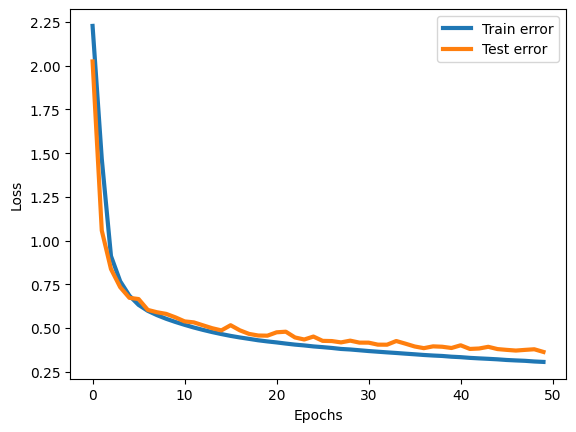

In [42]:
plt.plot(range(50),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(50),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.grid(True)
plt.legend()
plt.show()

Now, let us choose 3 random images from the dataset and plot the predicted and true labels for those images. We will have to apply softmax activation function because we had a linear output layer when we trained the neural network above. CrossEntropyLoss automatically applies softmax in its loss calculations, so we are doing again here.

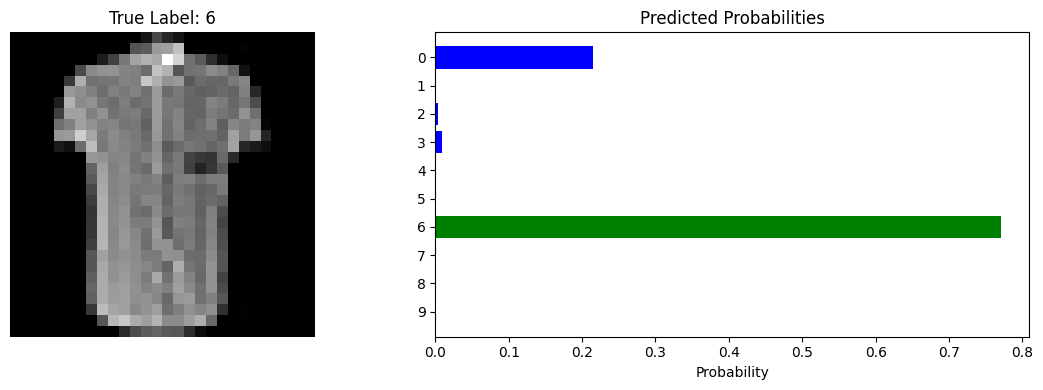

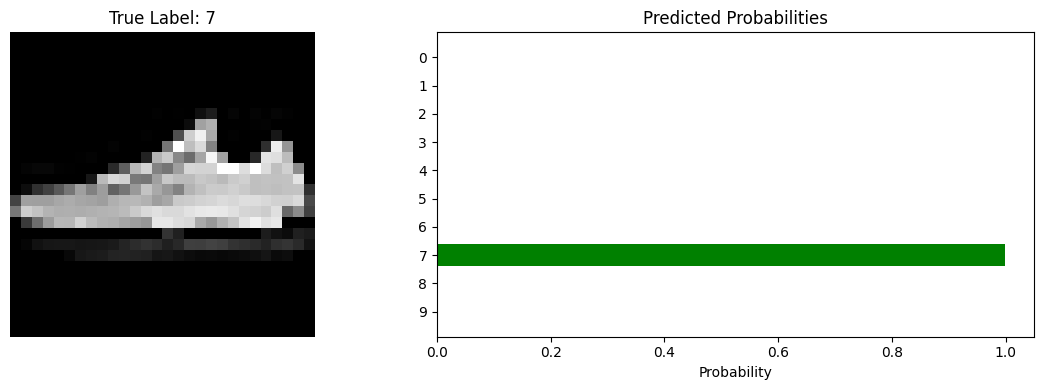

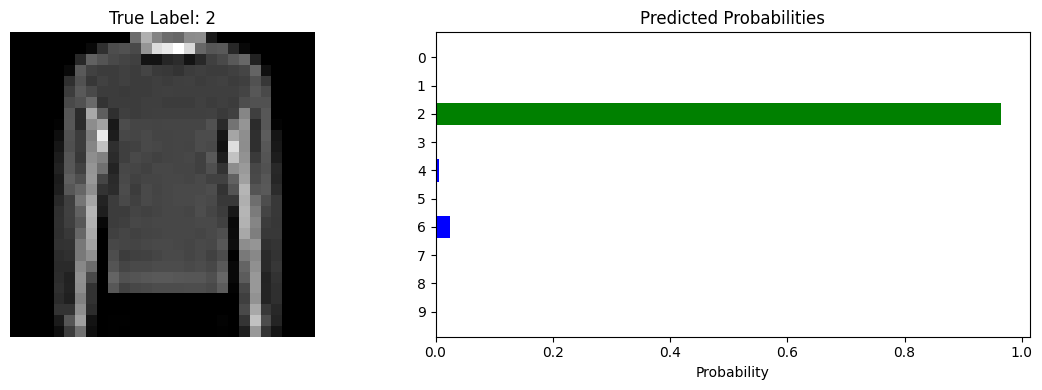

In [45]:
model.eval()
sample_indices = np.random.choice(len(testdata), 3, replace=False)    # Choose three random samples from the test dataset
true_class_color = 'green'
predicted_class_color = 'blue'

# loop for the predicted class probabilities for each sample
for index in sample_indices:
    with torch.no_grad():
        image, true_label = testdata[index]
        image = image.cuda().view(-1, 28*28)
        predicted_output = model(image)   # Forward pass to get the predicted probabilities because we had used a linear layer before
        probabilities = F.softmax(predicted_output, dim=1).squeeze().cpu().numpy()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.imshow(image.cpu().view(28, 28), cmap=plt.cm.gray)
        ax1.set_title(f"True Label: {true_label}")
        ax1.axis('off')

        # Plot the predicted class probabilities with colors
        bar_colors = [predicted_class_color if i != true_label else true_class_color for i in range(10)]
        ax2.barh(range(10), probabilities, color=bar_colors)
        ax2.set_yticks(range(10))
        ax2.set_yticklabels([str(i) for i in range(10)])
        ax2.set_title("Predicted Probabilities")
        ax2.set_xlabel("Probability")
        ax2.invert_yaxis()  # Invert y-axis for better chart
        plt.tight_layout()
        plt.show()

## Inference:

- We can see that the classifier performs well after adding hidden layers which are fully connected.
- It can be interpreted that every subsequent layer in the neural network will pick up more minute details. Let's say the first layer will pik up the sections of the image. Next layer can pick up edges in that selected section of the image.
- So, effectively, we are picking up more details with fully connected layers and thus we are able to identify distinct features in detail which can be a distinguishing factor while classifying closely linked yet different classes of objects.